# Explore_zillow

Create a python script or jupyter notebook named explore_zillow that does the following:

In [1]:
import pandas as pd
import wrangle_zillow
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
# Acquire
zillow = wrangle_zillow.read_zillow()

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (37,38,62,65,66,68) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [3]:
# Prep

df = wrangle_zillow.data_prep(zillow)

# Explore

Plot all continuous or numeric/ordered variables against each other in scatterplots, or through a pairplot.

In [4]:
# sns.pairplot(df)

Plot a correlation matrix heatmap.

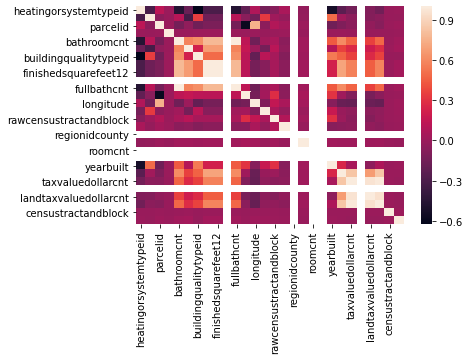

In [5]:
sns.heatmap(df.corr())

Plot latitude agains longitude

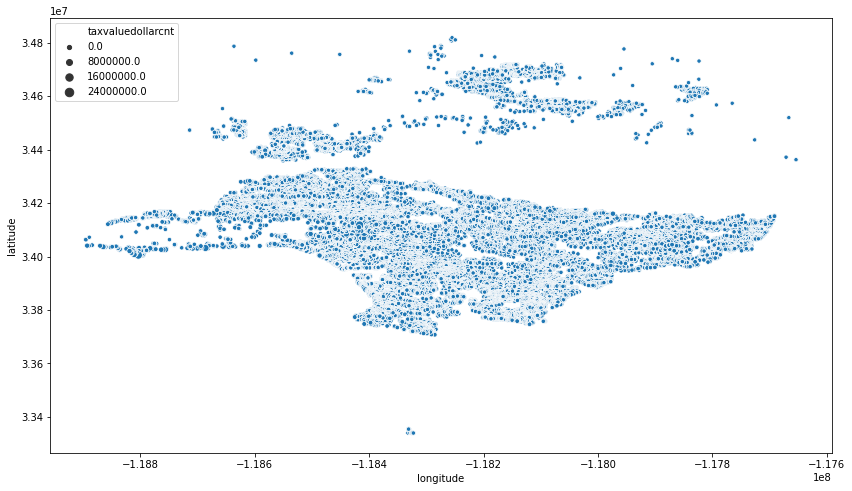

In [54]:
plt.figure(figsize=(14,8))
sns.scatterplot(data=df, y="latitude", x="longitude", size="taxvaluedollarcnt")
plt.legend()
plt.show()

Create a useable plot with 4 dimensions, e.g. x, y, color, size.

In [7]:
df["house_value_bins"] = pd.cut(df.taxamount, 3,labels=["low", "med", "high"])

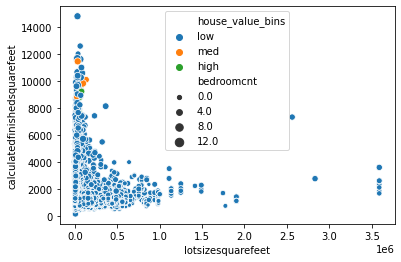

In [8]:
sns.scatterplot(data=df, x="lotsizesquarefeet", y="calculatedfinishedsquarefeet", hue="house_value_bins", size="bedroomcnt")

Compute the mean(logerror) by zipcode and the overall mean(logerror). Write a loop that will run a t-test between the overall mean and the mean for each zip code. We want to identify the zip codes where the error is significantly higher or lower than the expected error.

In [9]:
df.regionidzip.value_counts().index[0]

97319.0

* $H_0$: The difference in expected error in zipcode x will not be significantly different from the expected error 

* $H_a$: The difference in expected error in zipcode x will be significantly different from the expected error

In [10]:
list_diff = []
alpha = .01
for i in range(0,276):
    zipcode = df.regionidzip.value_counts().index[i]
    subgroup = df[df.regionidzip == zipcode].logerror
    tstat, p = stats.ttest_1samp(subgroup, df.logerror.mean())
    if p < alpha:
        value = [zipcode, df[df.regionidzip == zipcode].logerror.mean()]
        list_diff.append(value)
        
zipcodes = pd.DataFrame(list_diff, columns=["zipcode", "mean_log_error"])
zipcodes

/usr/local/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3506: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,zipcode,mean_log_error
0,96378.0,-0.008959
1,96379.0,0.033575
2,96387.0,0.041785
3,96047.0,-0.025855
4,96120.0,-0.022396
5,96197.0,0.039469
6,96336.0,0.033356
7,96026.0,-0.006342
8,96465.0,0.035788
9,96294.0,-0.018069


In [11]:
(zipcodes.mean_log_error > 0).mean()

0.391304347826087

We see that there are actually 22 zipcodes in total that differ significantly when it comes to log error. About 40% of them are overshooting (their prediction was higher than the higher) and the rest are undershooting. 

Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

* $H_0$: There is no significant difference in mean error between the three counties
* $H_a$: There is a significant difference in mean error between the three counties


In [12]:
zillow = wrangle_zillow.read_zillow()

In [13]:
geo_data = wrangle_zillow.wrangle_geo_data(zillow)

In [32]:
# first do a one tail test against the group mean
for i in range(0,3):
    county = geo_data.county.value_counts().index[i]
    subgroup = geo_data[geo_data.county == county].logerror
    tstat, p = stats.ttest_1samp(subgroup, geo_data.logerror.mean())
    print(f'{county}, p = {p:.2f}')

Los Angeles, p = 0.01
Orange County, p = 0.00
Ventura County, p = 0.63


In [43]:
def ttail_t_test(county_1, county_2):
    alpha = 0.05
    subgroup_1 = geo_data[geo_data.county == county_1].logerror
    subgroup_2 = geo_data[geo_data.county == county_2].logerror
    
    tstats, p = stats.ttest_ind(subgroup_1, subgroup_2)
    
    reject = "Because p is less than 0.05, we reject the null hypothesis"
    fail_reject = "Because p is more than 0.05, we fail to reject the null hypothesis"

    if p < alpha:
        print(f'''
            {reject}
            The mean_logerror for LA = {subgroup_1.mean():.2f}
            The mean_logerror for Orange County = {subgroup_2.mean():.2}
            ''')
    else:
        print(f'''
            {fail_reject}
            The mean_logerror for LA = {subgroup_1.mean():.2f}
            The mean_logerror for Orange County = {subgroup_2.mean():.2}
            ''')

In [44]:
ttail_t_test("Los Angeles", "Orange County")


            Because p is less than 0.05, we reject the null hypothesis
            The mean_logerror for LA = 0.01
            The mean_logerror for Orange County = 0.022
            


In [45]:
ttail_t_test("Los Angeles", "Ventura County")


            Because p is more than 0.05, we fail to reject the null hypothesis
            The mean_logerror for LA = 0.01
            The mean_logerror for Orange County = 0.016
            


In [46]:
ttail_t_test("Orange County", "Ventura County")


            Because p is less than 0.05, we reject the null hypothesis
            The mean_logerror for LA = 0.02
            The mean_logerror for Orange County = 0.016
            
